<a href="https://colab.research.google.com/github/emrbasr/ImageProcessing/blob/main/goruntu_isleme_bootcamp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rrebirrth/animals-with-attributes-2")

print("Path to dataset files:", path)

100%|██████████| 13.0G/13.0G [02:33<00:00, 90.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1


In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Sabit parametreler
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
MAX_IMAGES_PER_CLASS = 650

# CNN Modeli parametreleri
NUM_CLASSES = 10  # Hayvan sınıfı sayısı

def list_image_paths(base_path):
    """Belirli hayvanların görüntü yollarını listeler"""
    animals = ["collie", "dolphin", "elephant", "fox", "moose",
               "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

    image_paths = {}

    for animal in animals:
        animal_paths = []
        for root, _, files in os.walk(base_path):
            # Hayvan adını kontrol ederken + işaretini de göz önünde bulundur
            if any(a in root.lower() for a in [animal, animal.replace('+', ' ')]):
                for file in files:
                    if file.lower().endswith((".png", ".jpg", ".jpeg")):
                        full_path = os.path.join(root, file)
                        animal_paths.append(full_path)

        # Her sınıftan sadece ilk 650 resmi al
        image_paths[animal] = animal_paths[:MAX_IMAGES_PER_CLASS]
        print(f"{animal}: {len(image_paths[animal])} images found")

    return image_paths

def preprocess_image(file_path):
    """Görüntüyü ön işleme fonksiyonu"""
    img = tf.io.read_file(file_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0  # Normalize et
    # Görüntü boyutunu belirle
    img = tf.ensure_shape(img, [*IMAGE_SIZE, 3])
    return img

def create_dataset(image_paths):
    """TensorFlow veri seti oluşturma"""
    # Görüntü yolları ve etiketleri hazırla
    all_paths = []
    all_labels = []

    for animal, paths in image_paths.items():
        all_paths.extend(paths)
        all_labels.extend([animal] * len(paths))

    # Label encoding
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(all_labels)

    # Train-test split
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        all_paths, encoded_labels, test_size=0.3, random_state=42
    )

    # Veri setini oluşturma fonksiyonu
    def make_dataset(paths, labels):
        dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
        dataset = dataset.map(
            lambda x, y: (preprocess_image(x), tf.one_hot(y, NUM_CLASSES)),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    # Train ve test datasetlerini oluştur
    train_dataset = make_dataset(train_paths, train_labels)
    test_dataset = make_dataset(test_paths, test_labels)

    return train_dataset, test_dataset, label_encoder

# Veri artırma fonksiyonu
def augment_dataset(dataset):
    """Veri artırma için fonksiyon"""
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2)
    ])

    augmented_dataset = dataset.map(
        lambda x, y: (data_augmentation(x, training=True), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return augmented_dataset

# CNN Modeli tanımlama
def create_cnn_model():
    """CNN modelini oluştur"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Kullanım
base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"
image_paths = list_image_paths(base_path)

# Veri setini oluştur
train_dataset, test_dataset, label_encoder = create_dataset(image_paths)

# Veri artırma (isteğe bağlı)
augmented_train_dataset = augment_dataset(train_dataset)

# Modeli oluştur ve eğit
model = create_cnn_model()
model.fit(augmented_train_dataset, epochs=3, validation_data=test_dataset)

# Boyutları kontrol et
print("Train dataset boyutu:", tf.data.experimental.cardinality(train_dataset).numpy())
print("Test dataset boyutu:", tf.data.experimental.cardinality(test_dataset).numpy())
print("Sınıf etiketleri:", label_encoder.classes_)


collie: 650 images found
dolphin: 650 images found
elephant: 650 images found
fox: 650 images found
moose: 650 images found
rabbit: 650 images found
sheep: 650 images found
squirrel: 650 images found
giant+panda: 650 images found
polar+bear: 650 images found
Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 786s 5s/step - accuracy: 0.1853 - loss: 2.1771 - val_accuracy: 0.3810 - val_loss: 1.7779
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 669s 5s/step - accuracy: 0.3457 - loss: 1.8272 - val_accuracy: 0.4708 - val_loss: 1.5552
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.3978 - loss: 1.6957 - val_accuracy: 0.4656 - val_loss: 1.4975
Train dataset boyutu: 143
Test dataset boyutu: 61
Sınıf etiketleri: ['collie' 'dolphin' 'elephant' 'fox' 'giant+panda' 'moose' 'polar+bear'
 'rabbit' 'sheep' 'squirrel']


In [ ]:
import cv2

def get_manipulated_images(dataset, output_dir):
    """Test setini farklı ışık koşullarına göre manipüle eder ve kaydeder."""
    os.makedirs(output_dir, exist_ok=True)
    for i, (images, labels) in enumerate(dataset.unbatch().take(50)):  # İlk 50 resmi işle
        img_np = images.numpy()
        label = np.argmax(labels.numpy())  # Etiketi çöz
        filename = f"image_{i}_label_{label}.jpg"

        # Daha parlak bir versiyon oluştur
        brighter_img = cv2.convertScaleAbs(img_np * 255.0, alpha=1.5, beta=30)
        cv2.imwrite(os.path.join(output_dir, f"brighter_{filename}"), brighter_img)

        # Daha karanlık bir versiyon oluştur
        darker_img = cv2.convertScaleAbs(img_np * 255.0, alpha=0.8, beta=-30)
        cv2.imwrite(os.path.join(output_dir, f"darker_{filename}"), darker_img)


In [ ]:
manipulated_dir = "manipulated_images"
get_manipulated_images(test_dataset, manipulated_dir)
print(f"Manipüle edilmiş görüntüler {manipulated_dir} dizinine kaydedildi.")


Manipüle edilmiş görüntüler manipulated_images dizinine kaydedildi.


In [ ]:
def evaluate_manipulated_images(model, manipulated_dir, label_encoder, image_size=(224, 224)):
    """
    Manipüle edilmiş görüntülerle modeli test eder ve sonuçları kaydeder
    """
    results = {
        'brighter': {'correct': 0, 'total': 0},
        'darker': {'correct': 0, 'total': 0}
    }

    # Manipüle edilmiş görüntüleri yükle ve değerlendir
    for img_type in ['brighter', 'darker']:
        print(f"\nDeğerlendiriliyor: {img_type} görüntüler")

        # İlgili görüntüleri bul
        img_files = [f for f in os.listdir(manipulated_dir) if f.startswith(img_type)]

        for img_file in img_files:
            # Gerçek etiketi dosya adından al
            true_label = int(img_file.split('_label_')[1].split('.')[0])

            # Görüntüyü yükle ve ön işle
            img_path = os.path.join(manipulated_dir, img_file)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3, expand_animations=False)
            img = tf.image.resize(img, image_size)
            img = img / 255.0
            img = tf.expand_dims(img, 0)  # Batch boyutu ekle

            # Tahmin yap
            prediction = model.predict(img, verbose=0)
            predicted_label = np.argmax(prediction[0])

            # Sonuçları kaydet
            results[img_type]['total'] += 1
            if predicted_label == true_label:
                results[img_type]['correct'] += 1

            # İlerleme durumunu göster
            if results[img_type]['total'] % 10 == 0:
                print(f"İşlenen görüntü sayısı: {results[img_type]['total']}")

    # Sonuçları yazdır ve kaydet
    print("\nTest Sonuçları:")
    print("-" * 50)

    with open('manipulated_test_results.txt', 'w', encoding='utf-8') as f:
        for img_type, scores in results.items():
            accuracy = (scores['correct'] / scores['total'] * 100) if scores['total'] > 0 else 0
            result_text = f"{img_type.capitalize()} görüntüler:\n" \
                         f"Doğru tahmin: {scores['correct']}\n" \
                         f"Toplam görüntü: {scores['total']}\n" \
                         f"Doğruluk oranı: {accuracy:.2f}%\n"

            print(result_text)
            f.write(result_text + "\n")

    return results

# Test setini değerlendir
print("Manipüle edilmiş görüntülerle test başlıyor...")
results = evaluate_manipulated_images(model, manipulated_dir, label_encoder)

Manipüle edilmiş görüntülerle test başlıyor...

Değerlendiriliyor: brighter görüntüler
İşlenen görüntü sayısı: 10
İşlenen görüntü sayısı: 20
İşlenen görüntü sayısı: 30
İşlenen görüntü sayısı: 40
İşlenen görüntü sayısı: 50

Değerlendiriliyor: darker görüntüler
İşlenen görüntü sayısı: 10
İşlenen görüntü sayısı: 20
İşlenen görüntü sayısı: 30
İşlenen görüntü sayısı: 40
İşlenen görüntü sayısı: 50

Test Sonuçları:
--------------------------------------------------
Brighter görüntüler:
Doğru tahmin: 3
Toplam görüntü: 50
Doğruluk oranı: 6.00%

Darker görüntüler:
Doğru tahmin: 9
Toplam görüntü: 50
Doğruluk oranı: 18.00%



In [ ]:
import numpy as np
import cv2

def gray_world(img):
    """
    Gray World renk sabitliği algoritması
    """
    img_float = img.astype(float)
    avg_r = np.mean(img_float[:, :, 0])
    avg_g = np.mean(img_float[:, :, 1])
    avg_b = np.mean(img_float[:, :, 2])

    avg_gray = (avg_r + avg_g + avg_b) / 3

    scaling_r = avg_gray / avg_r if avg_r != 0 else 1
    scaling_g = avg_gray / avg_g if avg_g != 0 else 1
    scaling_b = avg_gray / avg_b if avg_b != 0 else 1

    balanced = img_float.copy()
    balanced[:, :, 0] *= scaling_r
    balanced[:, :, 1] *= scaling_g
    balanced[:, :, 2] *= scaling_b

    return np.clip(balanced, 0, 255).astype(np.uint8)

def get_wb_images(dataset, output_dir):
    """
    Test setine renk sabitliği uygula ve kaydet
    """
    os.makedirs(output_dir, exist_ok=True)

    for i, (images, labels) in enumerate(dataset.unbatch().take(50)):
        img_np = (images.numpy() * 255).astype(np.uint8)
        label = np.argmax(labels.numpy())

        # Gray World algoritmasını uygula
        wb_img = gray_world(img_np)

        # Sonucu kaydet
        filename = f"wb_image_{i}_label_{label}.jpg"
        cv2.imwrite(os.path.join(output_dir, filename), cv2.cvtColor(wb_img, cv2.COLOR_RGB2BGR))

def evaluate_all_test_sets(model, original_dataset, manipulated_dir, wb_dir, label_encoder):
    """
    Tüm test setlerini değerlendir ve sonuçları karşılaştır
    """
    results = {
        'original': {'correct': 0, 'total': 0},
        'brighter': {'correct': 0, 'total': 0},
        'darker': {'correct': 0, 'total': 0},
        'white_balanced': {'correct': 0, 'total': 0}
    }

    # Orijinal test setini değerlendir
    print("\nOrijinal test seti değerlendiriliyor...")
    for images, labels in original_dataset:
        predictions = model.predict(images, verbose=0)
        true_labels = np.argmax(labels, axis=1)
        pred_labels = np.argmax(predictions, axis=1)

        results['original']['correct'] += np.sum(true_labels == pred_labels)
        results['original']['total'] += len(true_labels)

    # Manipüle edilmiş ve renk sabitliği uygulanmış görüntüleri değerlendir
    for test_type, directory in [('manipulated', manipulated_dir), ('wb', wb_dir)]:
        for img_type in ['brighter', 'darker'] if test_type == 'manipulated' else ['wb']:
            print(f"\n{img_type.capitalize()} görüntüler değerlendiriliyor...")

            img_files = [f for f in os.listdir(directory) if f.startswith(img_type if test_type == 'manipulated' else 'wb')]

            for img_file in img_files:
                true_label = int(img_file.split('_label_')[1].split('.')[0])

                img_path = os.path.join(directory, img_file)
                img = tf.io.read_file(img_path)
                img = tf.image.decode_image(img, channels=3, expand_animations=False)
                img = tf.image.resize(img, IMAGE_SIZE)
                img = img / 255.0
                img = tf.expand_dims(img, 0)

                prediction = model.predict(img, verbose=0)
                predicted_label = np.argmax(prediction[0])

                result_key = img_type if test_type == 'manipulated' else 'white_balanced'
                results[result_key]['total'] += 1
                if predicted_label == true_label:
                    results[result_key]['correct'] += 1

    # Sonuçları kaydet ve raporla
    with open('test_results_comparison.txt', 'w', encoding='utf-8') as f:
        f.write("Test Setleri Karşılaştırma Raporu\n")
        f.write("=" * 50 + "\n\n")

        for test_type, scores in results.items():
            accuracy = (scores['correct'] / scores['total'] * 100) if scores['total'] > 0 else 0
            report = f"{test_type.capitalize()} Test Seti:\n" \
                     f"Doğru tahmin: {scores['correct']}\n" \
                     f"Toplam görüntü: {scores['total']}\n" \
                     f"Doğruluk oranı: {accuracy:.2f}%\n\n"

            f.write(report)
            print(report)

        # Eğer skorlar düşükse öneriler
        lowest_accuracy = min([(scores['correct'] / scores['total'] * 100) if scores['total'] > 0 else 0
                             for scores in results.values()])

        if lowest_accuracy < 60:
            improvement_suggestions = """
            İyileştirme Önerileri:
            1. Veri Artırma Stratejileri:
               - Farklı ışık koşullarında daha fazla veri ekleyin
               - Kontrast ve parlaklık değişimleri ile veri artırın

            2. Model Mimarisi:
               - Daha derin bir ağ kullanın
               - Batch normalization ekleyin
               - Dropout oranlarını ayarlayın

            3. Eğitim Stratejisi:
               - Öğrenme oranını düşürün
               - Daha uzun süre eğitim yapın
               - Farklı optimizer'lar deneyin

            4. Ön İşleme:
               - Farklı renk sabitliği algoritmaları deneyin
               - Histogram eşitleme uygulayın
               - Gürültü azaltma teknikleri ekleyin
            """
            f.write("\nİyileştirme Önerileri:\n" + improvement_suggestions)
            print("\nİyileştirme Önerileri:\n" + improvement_suggestions)

# Ana işlem akışı
wb_dir = "white_balanced_images"

# Renk sabitliği uygula
print("Renk sabitliği uygulanıyor...")
get_wb_images(test_dataset, wb_dir)

# Tüm test setlerini değerlendir ve karşılaştır
print("Tüm test setleri değerlendiriliyor...")
evaluate_all_test_sets(model, test_dataset, manipulated_dir, wb_dir, label_encoder)

Renk sabitliği uygulanıyor...
Tüm test setleri değerlendiriliyor...

Orijinal test seti değerlendiriliyor...

Brighter görüntüler değerlendiriliyor...

Darker görüntüler değerlendiriliyor...

Wb görüntüler değerlendiriliyor...
Original Test Seti:
Doğru tahmin: 908
Toplam görüntü: 1950
Doğruluk oranı: 46.56%


Brighter Test Seti:
Doğru tahmin: 3
Toplam görüntü: 50
Doğruluk oranı: 6.00%


Darker Test Seti:
Doğru tahmin: 9
Toplam görüntü: 50
Doğruluk oranı: 18.00%


White_balanced Test Seti:
Doğru tahmin: 20
Toplam görüntü: 50
Doğruluk oranı: 40.00%



İyileştirme Önerileri:

            İyileştirme Önerileri:
            1. Veri Artırma Stratejileri:
               - Farklı ışık koşullarında daha fazla veri ekleyin
               - Kontrast ve parlaklık değişimleri ile veri artırın
            
            2. Model Mimarisi:
               - Daha derin bir ağ kullanın
               - Batch normalization ekleyin
               - Dropout oranlarını ayarlayın
            
            3. Eğ

Örnek görüntüler gösteriliyor...


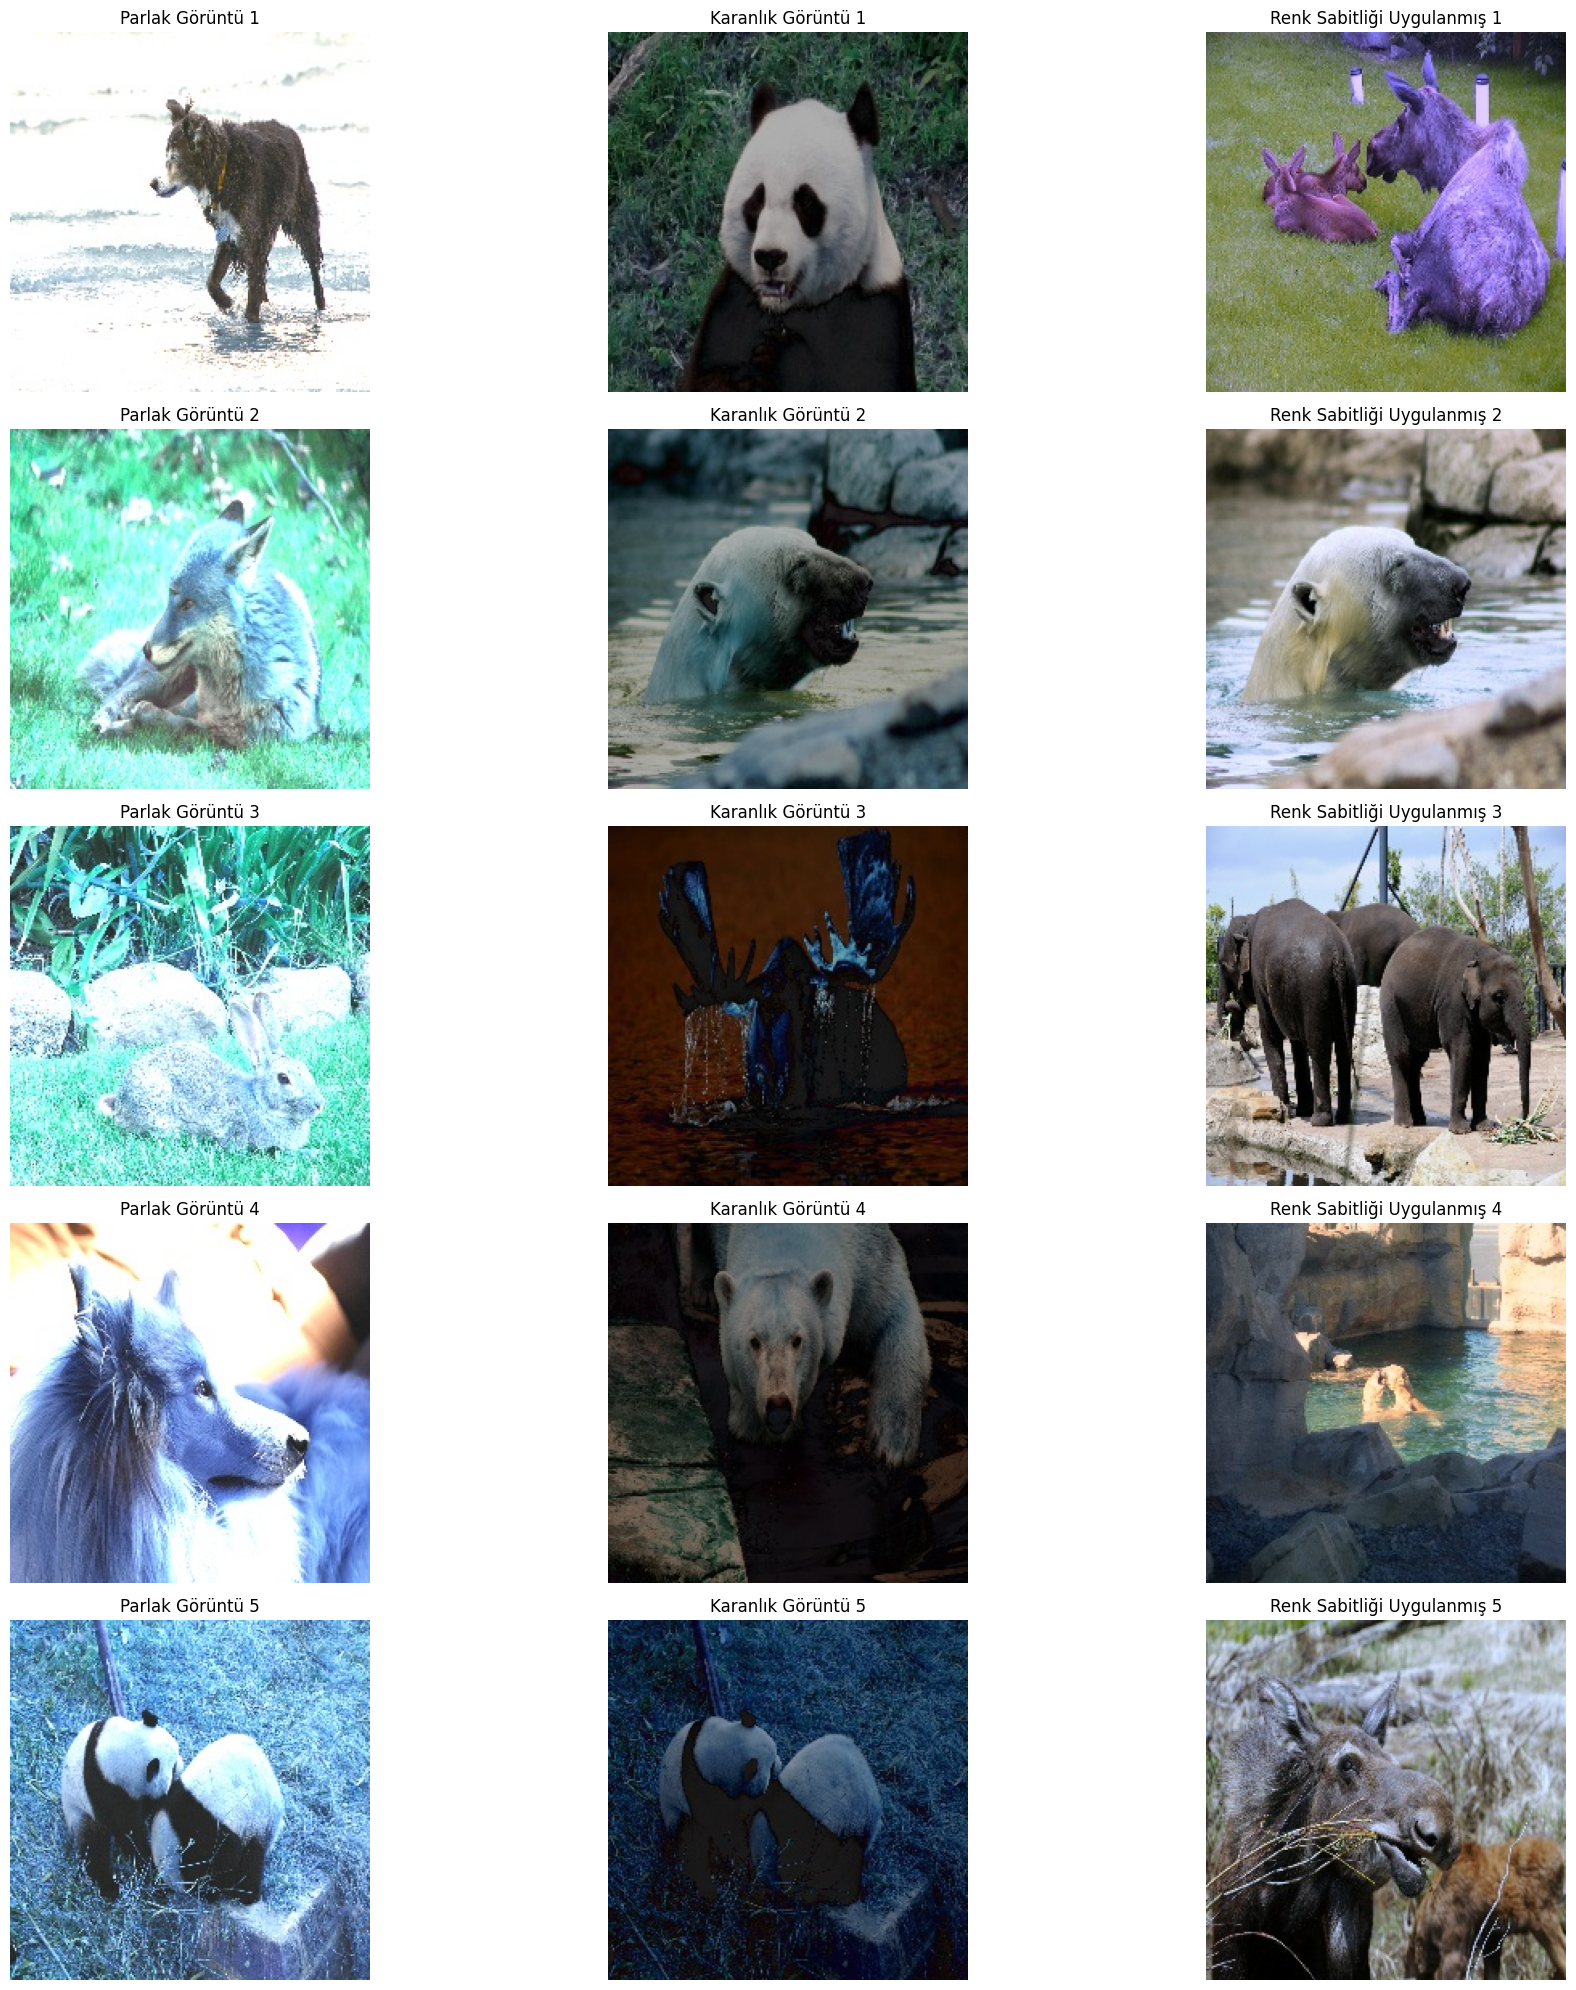

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, Image

def display_sample_images(original_dir, manipulated_dir, wb_dir, num_samples=5):
    """
    Her kategoriden örnek görüntüleri yan yana gösterir
    """
    plt.figure(figsize=(20, 4*num_samples))

    # Manipüle edilmiş görüntüleri bul
    brighter_images = [f for f in os.listdir(manipulated_dir) if f.startswith('brighter')]
    darker_images = [f for f in os.listdir(manipulated_dir) if f.startswith('darker')]
    wb_images = [f for f in os.listdir(wb_dir) if f.startswith('wb')]

    for i in range(min(num_samples, len(brighter_images))):
        # Görüntüleri oku
        brighter_img = cv2.imread(os.path.join(manipulated_dir, brighter_images[i]))
        darker_img = cv2.imread(os.path.join(manipulated_dir, darker_images[i]))
        wb_img = cv2.imread(os.path.join(wb_dir, wb_images[i]))

        # BGR'den RGB'ye çevir
        brighter_img = cv2.cvtColor(brighter_img, cv2.COLOR_BGR2RGB)
        darker_img = cv2.cvtColor(darker_img, cv2.COLOR_BGR2RGB)
        wb_img = cv2.cvtColor(wb_img, cv2.COLOR_BGR2RGB)

        # Alt plotları oluştur
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(brighter_img)
        plt.title(f'Parlak Görüntü {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(darker_img)
        plt.title(f'Karanlık Görüntü {i+1}')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(wb_img)
        plt.title(f'Renk Sabitliği Uygulanmış {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Önceki kodlarınızın sonuna ekleyin:
print("Örnek görüntüler gösteriliyor...")
display_sample_images(manipulated_dir, manipulated_dir, wb_dir)

# Ayrıca, get_wb_images ve get_manipulated_images fonksiyonlarına görselleştirme ekleyelim
def get_wb_images(dataset, output_dir):
    """
    Test setine renk sabitliği uygula ve kaydet
    """
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(15, 5))
    for i, (images, labels) in enumerate(dataset.unbatch().take(50)):
        img_np = (images.numpy() * 255).astype(np.uint8)
        label = np.argmax(labels.numpy())

        # Gray World algoritmasını uygula
        wb_img = gray_world(img_np)

        # Her 10 görüntüde bir örnek göster
        if i < 3:  # İlk 3 görüntüyü göster
            plt.subplot(1, 3, i+1)
            plt.imshow(wb_img)
            plt.title(f'White Balanced Image {i+1}\nLabel: {label}')
            plt.axis('off')

        # Sonucu kaydet
        filename = f"wb_image_{i}_label_{label}.jpg"
        cv2.imwrite(os.path.join(output_dir, filename), cv2.cvtColor(wb_img, cv2.COLOR_RGB2BGR))

    plt.tight_layout()
    plt.show()

def get_manipulated_images(dataset, output_dir):
    """
    Test setini farklı ışık koşullarına göre manipüle eder
    """
    os.makedirs(output_dir, exist_ok=True)

    plt.figure(figsize=(15, 5))
    for i, (images, labels) in enumerate(dataset.unbatch().take(50)):
        img_np = images.numpy()
        label = np.argmax(labels.numpy())

        # Görüntüleri manipüle et
        brighter_img = cv2.convertScaleAbs(img_np * 255.0, alpha=1.5, beta=30)
        darker_img = cv2.convertScaleAbs(img_np * 255.0, alpha=0.8, beta=-30)

        # Her 10 görüntüde bir örnek göster
        if i < 3:  # İlk 3 görüntüyü göster
            plt.subplot(1, 3, i+1)
            plt.imshow(np.hstack([brighter_img, darker_img]))
            plt.title(f'Bright vs Dark Image {i+1}\nLabel: {label}')
            plt.axis('off')

        # Görüntüleri kaydet
        cv2.imwrite(os.path.join(output_dir, f"brighter_image_{i}_label_{label}.jpg"),
                   cv2.cvtColor(brighter_img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(output_dir, f"darker_image_{i}_label_{label}.jpg"),
                   cv2.cvtColor(darker_img, cv2.COLOR_RGB2BGR))

    plt.tight_layout()
    plt.show()